In [42]:
from cosapp.base import System
from cosapp.drivers import RunOnce
import numpy as np

# **Global System**

In [31]:
class Earth(System):

    def setup(self):

        self.add_child(Gravity('grav'))
        self.add_child(Atmosphere('atmo'))
        self.add_child(Trajectory('traj'))
        self.add_child(Rocket('rocket'))
        self.add_child(Reservatory('reserv'))

# **Earth Properties**

In [3]:
class Gravity(System):

    def setup(self):

        self.add_inward('x')

In [4]:
class Atmosphere(System):

    def setup(self):

        self.add_child(Density('dens'))
        self.add_child(Pressure('pres'))

In [5]:
class Pressure(System):

    def setup(self):

        self.add_inward('x')

In [6]:
class Density(System):

    def setup(self):

        self.add_inward('x')

# **Station's Reservatory**

In [7]:
class Reservatory(System):
    
    def setup(self):
        
        self.add_inward('x')

# **Rocket Trajectory**

In [8]:
class Trajectory(System):

    def setup(self):

        self.add_inward('x')

# **Rocket System**

In [26]:
class Rocket(System):

    def setup(self):

        self.add_child(Fins('fins'))
        self.add_child(Nose('nose'))
        self.add_child(Tube('tube'))
        self.add_child(Engine('engine'))
        self.add_child(Tank('tank'))
        self.add_child(RocketAero('aero'))
        self.add_child(RocketGeom('geom'))
        self.add_child(Dynamics('dyn'))
        self.add_child(Kinematics('kin'))

# **Rocket Components**

## Fins

In [29]:
class Fins(System):

    def setup(self):
        
        #Fins children
        self.add_child(FinsGeom('geom'))
        self.add_child(FinsAero('aero'))

        #Geometric Parameters
        self.add_inward('s', 0.1, desc="Span of one fin", unit='m')
        self.add_inward('Cr', 0.1, desc="", unit='m')
        self.add_inward('Ct', 0.1, desc="", unit='m')
        self.add_inward('Xt', 0.1, desc="", unit='m')
        self.add_inward('delta', 0., desc="Cant angle", unit='')
        self.add_inward('tf', 0.001, desc="Fin thickness", unit='m')
        

In [11]:
class FinsGeom(System):
    
    def setup(self):
        
        self.add_inward('x')

In [12]:
class FinsAero(System):
    
    def setup(self):
        
        self.add_inward('x')

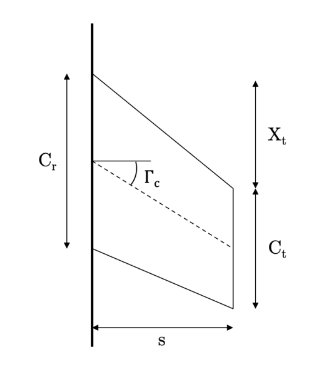

## Nose - Cone

In [47]:
class Nose(System):

    def setup(self):
        
        #Nose children
        self.add_child(NoseGeom('geom'), pulling=['R', 'L', 'rho'])
        self.add_child(NoseAero('aero'), pulling=['R', 'L'])
        
        #Nose parameters
        self.add_inward('R', 1., desc="Nose radius", unit='m')
        self.add_inward('L', 1., desc="Nose length", unit='m')
        self.add_inward('rho', 300., desc="Nose Density", unit='kg/m**3')
        

In [48]:
class NoseGeom(System):
    
    def setup(self):
        
        self.add_inward('R', 1., desc="Nose radius", unit='m')
        self.add_inward('L', 1., desc="Nose length", unit='m')
        self.add_inward('rho', 300., desc="Nose Density", unit='kg/m**3')
        
        self.add_outward('Xcg', 1., desc="Center of gravity x-coordinate", unit='m')
        self.add_outward('m', 1., desc="Nose mass", unit='kg')
        self.add_outward('I', np.ones(3), desc="Nose principal inertia moments", unit='kg*m**2')
        
    def compute(self):
        
        V = self.L*np.pi*self.R**2/3
        
        self.m = self.rho*V
        self.Xcg = 3*self.L/4
        
        Iz = (3/10)*self.m*self.R**2
        Ix = (3*self.m/20)*(self.R**2 + self.L**2/4)
        
        self.I = np.array([Ix, Ix, Iz])

In [15]:
class NoseAero(System):
    
    def setup(self):
        
        self.add_inward('R', 1., desc="Nose radius", unit='m')
        self.add_inward('L', 1., desc="Nose length", unit='m')
        
        self.add_outward('Cna', 2., desc="Nose normal force coefficient slope", unit='')
        self.add_outward('Cd', 1., desc="Nose drag coefficient", unit='')
        self.add_outward('Xcp', 1. desc="Nose center of pressure", unit='m')
        
    def compute(self):
        
        self.Xcp = 2*self.L/3
        self.Cd = 0.8*(self.R/np.sqrt(self.R**2 + self.L**2))

## Tube

In [30]:
class Tube(System):

    def setup(self):
        
        #Tube children
        self.add_child(TubeGeom('geom'))
        self.add_child(TubeAero('aero'))
        
        #Tube parameters
        self.add_inward('R', 1., desc="Tube radius", unit='m')
        self.add_inward('L', 1., desc="Tube length", unit='m')

In [17]:
class TubeGeom(System):
    
    def setup(self):
        
        self.add_inward('x')

In [18]:
class TubeAero(System):
    
    def setup(self):
        
        self.add_inward('x')

## Engine

In [19]:
class Engine(System):

    def setup(self):

        self.add_inward('x')

## Fuel Tank

In [20]:
class Tank(System):

    def setup(self):

        self.add_inward('x')

# **Rocket overall geometry and aerodynamics**

In [21]:
class RocketGeom(System):
    
    def setup(self):
        
        self.add_inward('x')

In [22]:
class RocketAero(System):
    
    def setup(self):
        
        self.add_inward('x')

# **Rocket Movement**

In [23]:
class Dynamics(System):

    def setup(self):

        self.add_inward('x')

In [24]:
class Kinematics(System):

    def setup(self):

        self.add_inward('x')

# **System Representation**

In [32]:
earth = Earth('earth')

In [33]:
earth

earth - Earth

In [43]:
class Ball(System):
    
    def setup(self):
        
        self.add_inward('a',5.)
        
        self.add_child(Ball2('ball2'), pulling=['a'])

In [44]:
class Ball2(System):
    
    def setup(self):
    
        self.add_inward('a', 1.)
        self.add_outward('b', 1.)
    
    def compute(self):
        
        self.b = 3*self.a

In [45]:
ball = Ball('ball')

ball.add_driver(RunOnce('run'))
ball.run_drivers()

In [46]:
ball.ball2.b

15.0